In [1]:
import datetime
now = datetime.datetime.now()
print ("The last edit : ", now.strftime("%Y-%m-%d %H:%M:%S"))

The last edit :  2019-04-01 08:25:01


In [24]:
import pandas as pd 
import lightgbm
import os
import math
os.environ['KMP_DUPLICATE_LIB_OK']='True'  # fix error on MAC_OS when using light gbm, xgboost
from sklearn.metrics import mean_squared_error

import lightgbm
import xgboost
import matplotlib.pyplot as plt

# Regression

In [3]:
df = pd.read_csv("./data.csv")
df["index_"] = range(len(df))
df

,sqfeet,rent,index_
0,750,1160,0
1,800,1200,1
2,850,1280,2
3,860,1300,3
4,900,1450,4
5,950,2000,5


## Objective = mse

In [4]:
def mse_gain_for_evey_split(df, f_derivative_col):
    
    gain_list =  list()
    residual_mean = df[f_derivative_col].mean()
    for i in range(1, len(df)):
        gain = 0
        first_half_gain = 0 
        second_half_gain = 0
        first_half_mean = 0
        second_half_mean = 0
        first_half = df.iloc[:i,:]
        second_half = df.iloc[i:,:]
        
        first_half_mean = np.round(first_half[f_derivative_col].mean(), 2)
        second_half_mean = np.round(second_half[f_derivative_col].mean(), 2)

        first_half_gain = np.sum(np.power(residual_mean - first_half[f_derivative_col], 2)) - \
                                np.sum(np.power(first_half_mean - first_half[f_derivative_col], 2))
        second_half_gain = np.sum(np.power(residual_mean - second_half[f_derivative_col], 2)) - \
                                np.sum(np.power(second_half_mean - second_half[f_derivative_col], 2))
        
        gain = np.round(first_half_gain + second_half_gain, 0)
        gain_list.append((gain, i, first_half_mean, second_half_mean)) # "gain" when splitting at index "i", note that
                                    # "index i" mean splitting df into df[:i] and df[i:]
    return gain_list


def mse_find_best_split(df, f_derivative_col):
    gain_list= mse_gain_for_evey_split(df, f_derivative_col)
    best_gain, best_index, first_half_mean, second_half_mean = max(gain_list)
    new_col = df.apply(lambda x: first_half_mean if x["index_"] < best_index else second_half_mean, 1)
    return new_col

## test:
df["F0"] = df.rent.mean()
df["F0_residual"] = df["rent"] - df["F0"] 
mse_gain_for_evey_split(df, "F0_residual")


[(68163.0, 1, -238.33, 47.67),
 (143008.0, 2, -218.33, 109.17),
 (205350.0, 3, -185.0, 185.0),
 (320133.0, 4, -163.33, 326.67),
 (434403.0, 5, -120.33, 601.67)]

### Check with normal GBT (Sklearn package)
#### One Tree (checked, ok)

In [5]:
df = pd.read_csv("./data.csv")
df["index_"] = range(len(df))


df["F0"] = df.rent.mean()
df["F0_residual"] = df["rent"] - df["F0"] 
df["h1"] = mse_find_best_split(df, "F0_residual")

df["F1"] = df["F0"] + df["h1"]
df["F0_error"] = np.power(df["rent"] - df["F0"] , 2)
df["F1_error"] = np.power(df["rent"] - df["F1"] , 2)


F1_gain = np.round( df["F0_error"].sum() -  df["F1_error"].sum(), 0)
print(F1_gain)

df

434403.0


,sqfeet,rent,index_,F0,F0_residual,h1,F1,F0_error,F1_error
0,750,1160,0,1398.333333,-238.333333,-120.33,1278.003333,56802.777778,13924.786678
1,800,1200,1,1398.333333,-198.333333,-120.33,1278.003333,39336.111111,6084.520011
2,850,1280,2,1398.333333,-118.333333,-120.33,1278.003333,14002.777778,3.986678
3,860,1300,3,1398.333333,-98.333333,-120.33,1278.003333,9669.444444,483.853344
4,900,1450,4,1398.333333,51.666667,-120.33,1278.003333,2669.444444,29582.853344
5,950,2000,5,1398.333333,601.666667,601.67,2000.003333,362002.777778,0.000011


In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
model = GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=1.0, min_weight_fraction_leaf=0.0,
             n_estimators=1, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.000001,
             validation_fraction=0, verbose=0, warm_start=False)

X = df[["sqfeet"]]
y = df.rent

model.fit(X, y)
y_pred = model.predict(X)


col_to_check = "F1"
print(np.round(df[col_to_check].values, 2))
print(y_pred)
np.round(mean_squared_error(df[col_to_check], y_pred), 4)

[1278. 1278. 1278. 1278. 1278. 2000.]
[1278. 1278. 1278. 1278. 1278. 2000.]


0.0

#### Two trees (checked, ok)

In [7]:
df = pd.read_csv("./data.csv")
df["index_"] = range(len(df))

df["F0"] = df.rent.mean()
df["F0_residual"] = df["rent"] - df["F0"] 
df["h1"] = mse_find_best_split(df, "F0_residual")

df["F1"] = df["F0"] + df["h1"]

df["F1_residual"] = df["rent"] - df["F1"] 
df["h2"] = mse_find_best_split(df, "F1_residual")

df["F2"] = df["F1"] + df["h2"]
df["F1_error"] = np.power(df["rent"] - df["F1"] , 2)
df["F2_error"] = np.power(df["rent"] - df["F2"] , 2)


F2_gain = np.round( df["F1_error"].sum() -  df["F2_error"].sum(), 0)
print(F2_gain)

df

28812.0


,sqfeet,rent,index_,F0,F0_residual,h1,F1,F1_residual,h2,F2,F1_error,F2_error
0,750,1160,0,1398.333333,-238.333333,-120.33,1278.003333,-118.003333,-98.0,1180.003333,13924.786678,400.133344
1,800,1200,1,1398.333333,-198.333333,-120.33,1278.003333,-78.003333,-98.0,1180.003333,6084.520011,399.866678
2,850,1280,2,1398.333333,-118.333333,-120.33,1278.003333,1.996667,49.0,1327.003333,3.986678,2209.313344
3,860,1300,3,1398.333333,-98.333333,-120.33,1278.003333,21.996667,49.0,1327.003333,483.853344,729.180011
4,900,1450,4,1398.333333,51.666667,-120.33,1278.003333,171.996667,49.0,1327.003333,29582.853344,15128.180011
5,950,2000,5,1398.333333,601.666667,601.67,2000.003333,-0.003333,49.0,2049.003333,0.000011,2401.326678


In [8]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=1.0, min_weight_fraction_leaf=0.0,
             n_estimators=2, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.000001,
             validation_fraction=0, verbose=0, warm_start=False)

X = df[["sqfeet"]]
y = df.rent

model.fit(X, y)
y_pred = model.predict(X)

col_to_check = "F2"
print(np.round(df[col_to_check].values, 2))
print(y_pred)
np.round(mean_squared_error(df[col_to_check], y_pred), 4)

[1180. 1180. 1327. 1327. 1327. 2049.]
[1180. 1180. 1327. 1327. 1327. 2049.]


0.0

=> It works like we expected

### Check with Light GBM 

#### One tree 

In [9]:
df = pd.read_csv("./data.csv")
df["index_"] = range(len(df))

df["F0"] = df.rent.mean()
df["F0_residual"] = df["rent"] - df["F0"] 
df["h1"] = mse_find_best_split(df, "F0_residual")

df["F1"] = df["F0"] + df["h1"]


lgbm = lightgbm.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=1, max_depth=1,
       min_child_samples=1, min_child_weight=0, min_split_gain=0.0,
       n_estimators=1, n_jobs=1, num_leaves=31, objective="mse",
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
       subsample=1.0, subsample_for_bin=2000, subsample_freq=0)

X = df[["sqfeet"]]
y = df.rent

lgbm.fit(X, y)
y_pred = lgbm.predict(X)

col_to_check = "F1"
print(np.round(df[col_to_check].values, 2))
print(np.round(y_pred, 2) )
np.round(mean_squared_error(df[col_to_check], y_pred), 4)

[1278. 1278. 1278. 1278. 1278. 2000.]
[1213.33 1213.33 1213.33 1583.33 1583.33 1583.33]


62102.2225

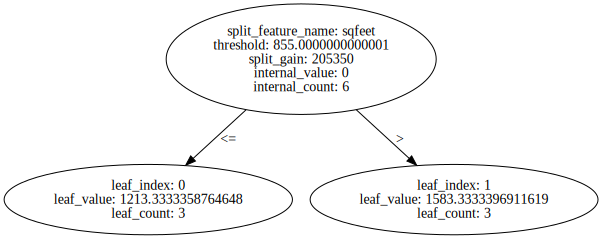

In [10]:
lightgbm.create_tree_digraph(lgbm, tree_index=0, show_info=["split_gain",
                                                 "internal_value", "internal_count", "leaf_count"] )

#### Two tree (checked, NOT the same, need to check again)

[1180. 1180. 1327. 1327. 1327. 2049.]
[1213.33 1213.33 1213.33 1583.33 1583.33 1583.33]
60566.8888


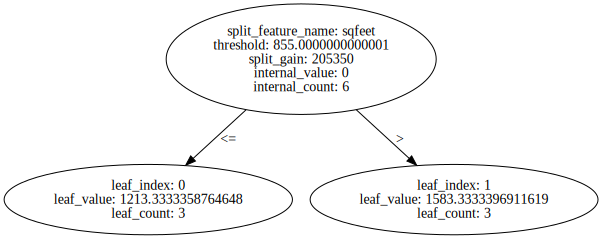

In [11]:
df = pd.read_csv("./data.csv")
df["index_"] = range(len(df))

df["F0"] = df.rent.mean()
df["F0_residual"] = df["rent"] - df["F0"] 
df["h1"] = mse_find_best_split(df, "F0_residual")

df["F1"] = df["F0"] + df["h1"]

df["F1_residual"] = df["rent"] - df["F1"] 
df["h2"] = mse_find_best_split(df, "F1_residual")

df["F2"] = df["F1"] + df["h2"]

lgbm = lightgbm.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=1, max_depth=1,
       min_child_samples=1, min_child_weight=0, min_split_gain=0.0,
       n_estimators=2, n_jobs=-1, num_leaves=31, objective="mse",
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
       subsample=1.0, subsample_for_bin=2000, subsample_freq=0)

X = df[["sqfeet"]]
y = df.rent

lgbm.fit(X, y)
y_pred = lgbm.predict(X)

col_to_check = "F2"
print(np.round(df[col_to_check].values, 2))
print(np.round(y_pred, 2) )
print(np.round(mean_squared_error(df[col_to_check], y_pred), 4))
f1 = lightgbm.create_tree_digraph(lgbm, tree_index=0, show_info=["split_gain",
                                                 "internal_value", "internal_count", "leaf_count"] )
f2 = lightgbm.create_tree_digraph(lgbm, tree_index=1, show_info=["split_gain",
                                                 "internal_value", "internal_count", "leaf_count"] )

f1

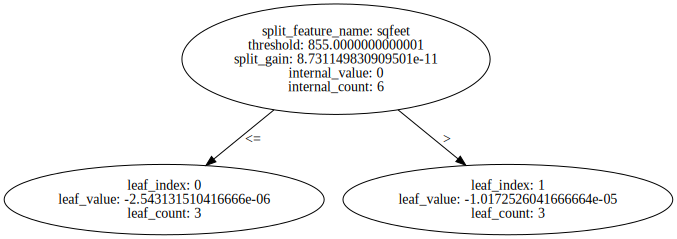

In [12]:
f2

### Check with XGBoost

#### One tree (checked, ok)

[1278. 1278. 1278. 1278. 1278. 2000.]
[1278. 1278. 1278. 1278. 1278. 2000.]
0.0


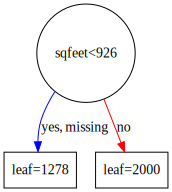

In [13]:
df = pd.read_csv("./data.csv")
df["index_"] = range(len(df))

df["F0"] = df.rent.mean()
df["F0_residual"] = df["rent"] - df["F0"] 
df["h1"] = mse_find_best_split(df, "F0_residual")

df["F1"] = df["F0"] + df["h1"]

xgb = xgboost.XGBRegressor(base_score=0, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=1,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

X = df[["sqfeet"]]
y = df.rent

xgb.fit(X, y)
y_pred = xgb.predict(X)

col_to_check = "F1"
print(np.round(df[col_to_check].values, 2))
print(np.round(y_pred, 2) )
print(np.round(mean_squared_error(df[col_to_check], y_pred), 4))

xgboost.to_graphviz(xgb, num_trees=0)

#### Two trees (checked, ok)

[1180. 1180. 1327. 1327. 1327. 2049.]
[1180. 1180. 1327. 1327. 1327. 2049.]
0.0


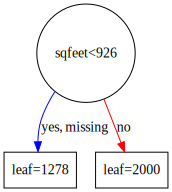

In [14]:
df = pd.read_csv("./data.csv")
df["index_"] = range(len(df))

df["F0"] = df.rent.mean()
df["F0_residual"] = df["rent"] - df["F0"] 
df["h1"] = mse_find_best_split(df, "F0_residual")

df["F1"] = df["F0"] + df["h1"]

df["F1_residual"] = df["rent"] - df["F1"] 
df["h2"] = mse_find_best_split(df, "F1_residual")

df["F2"] = df["F1"] + df["h2"]

xgb = xgboost.XGBRegressor(base_score=0, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=2,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

X = df[["sqfeet"]]
y = df.rent

xgb.fit(X, y)
y_pred = xgb.predict(X)

col_to_check = "F2"
print(np.round(df[col_to_check].values, 2))
print(np.round(y_pred, 2) )
print(np.round(mean_squared_error(df[col_to_check], y_pred), 4))
f1 = xgboost.to_graphviz(xgb, num_trees=0)
f2 = xgboost.to_graphviz(xgb, num_trees=1)

f1

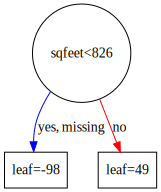

In [15]:
f2

## Objective = mae

In [16]:
def mae_gain_for_evey_split(df, f_derivate_col, residual_column):
    
    gain_list =  list()
    residual_mean = df[f_derivate_col].mean()
    for i in range(1, len(df)):
        gain = 0
        first_half_gain = 0 
        second_half_gain = 0
        first_half_mean = 0
        second_half_mean = 0
        
        first_half_median = 0 
        second_half_median = 0
        first_half = df.iloc[:i,:]
        second_half = df.iloc[i:,:]
        
        first_half_mean = np.round(first_half[f_derivate_col].mean(), 2)
        second_half_mean = np.round(second_half[f_derivate_col].mean(), 2)

        first_half_gain = np.sum(np.abs(residual_mean - first_half[f_derivate_col])) - \
                                np.sum(np.abs(first_half_mean - first_half[f_derivate_col]))
        second_half_gain = np.sum(np.abs(residual_mean - second_half[f_derivate_col])) - \
                                np.sum(np.abs(second_half_mean - second_half[f_derivate_col]))
        
        
        first_half_median = round(first_half[residual_column].median(), 2)
        second_half_median = round(second_half[residual_column].median(), 2)
        
        gain = np.round(first_half_gain + second_half_gain, 0)
        gain_list.append((gain, i, first_half_median, second_half_median)) # "gain" when splitting at index "i", note that
                                    # "index i" mean splitting df into df[:i] and df[i:]
    return gain_list

def mae_find_best_split(df, f_derivate_col, residual_column):
    gain_list= mae_gain_for_evey_split(df, f_derivate_col, residual_column)
    best_gain, best_index, first_half_median, second_half_median = max(gain_list)
    
    new_col = df.apply(lambda x: first_half_median if x["index_"] < best_index else second_half_median, 1)
    return new_col

## test:
df["F0"] = df.rent.mean()
df["F0_f'"] = df["rent"] - df["F0"] 
df["F0_f'"] = np.sign(df["F0_f'"]) 
mae_gain_for_evey_split(df,  "F0_f'", "F0_residual")


[(1.0, 1, -238.33, -98.33),
 (1.0, 2, -218.33, -23.33),
 (3.0, 3, -198.33, 51.67),
 (5.0, 4, -158.33, 326.67),
 (2.0, 5, -118.33, 601.67)]

### Check with normal GBT (Sklearn package)
#### One Tree (checked, ok)

In [17]:
df = pd.read_csv("./data.csv")
df["index_"] = range(len(df))


df["F0"] = df.rent.median()
df["F0_residual"] = df["rent"] - df["F0"] 
df["F0_f'"] = np.sign(df["F0_residual"] )
df["h1"] = mae_find_best_split(df, "F0_f'", "F0_residual")

df["F1"] = df["F0"] + df["h1"]
df["F0_error"] = np.abs(df["rent"] - df["F0"])
df["F1_error"] = np.abs(df["rent"] - df["F1"])


F1_gain = np.round( df["F0_error"].sum() -  df["F1_error"].sum(), 0)
print(F1_gain)

df

290.0


,sqfeet,rent,index_,F0,F0_residual,F0_f',h1,F1,F0_error,F1_error
0,750,1160,0,1290.0,-130.0,-1.0,-90.0,1200.0,130.0,40.0
1,800,1200,1,1290.0,-90.0,-1.0,-90.0,1200.0,90.0,0.0
2,850,1280,2,1290.0,-10.0,-1.0,-90.0,1200.0,10.0,80.0
3,860,1300,3,1290.0,10.0,1.0,160.0,1450.0,10.0,150.0
4,900,1450,4,1290.0,160.0,1.0,160.0,1450.0,160.0,0.0
5,950,2000,5,1290.0,710.0,1.0,160.0,1450.0,710.0,550.0


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
model = GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
             learning_rate=1, loss='lad', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=1.0, min_weight_fraction_leaf=0.0,
             n_estimators=1, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.000001,
             validation_fraction=0, verbose=0, warm_start=False)

X = df[["sqfeet"]]
y = df.rent

model.fit(X, y)
y_pred = model.predict(X)


col_to_check = "F1"
print(np.round(df[col_to_check].values, 2))
print(y_pred)
np.round(mean_squared_error(df[col_to_check], y_pred), 4)

[1200. 1200. 1200. 1450. 1450. 1450.]
[1200. 1200. 1200. 1450. 1450. 1450.]


0.0

#### Two trees

In [19]:
df = pd.read_csv("./data.csv")
df["index_"] = range(len(df))


df["F0"] = df.rent.median()
df["F0_residual"] = df["rent"] - df["F0"] 
df["F0_f'"] = np.sign(df["F0_residual"] )
df["h1"] = mae_find_best_split(df, "F0_f'", "F0_residual")

df["F1"] = df["F0"] + df["h1"]
df["F1_residual"] = df["rent"] - df["F1"] 
df["F1_f'"] = np.sign(df["F1_residual"] )
df["h2"] = mae_find_best_split(df, "F1_f'", "F1_residual")
df["F2"] = df["F1"] + df["h2"]

df["F1_error"] = np.abs(df["rent"] - df["F1"])
df["F2_error"] = np.abs(df["rent"] - df["F2"])


F2_gain = np.round( df["F1_error"].sum() -  df["F2_error"].sum(), 0)
print(F2_gain)
df

550.0


,sqfeet,rent,index_,F0,F0_residual,F0_f',h1,F1,F1_residual,F1_f',h2,F2,F1_error,F2_error
0,750,1160,0,1290.0,-130.0,-1.0,-90.0,1200.0,-40.0,-1.0,0.0,1200.0,40.0,40.0
1,800,1200,1,1290.0,-90.0,-1.0,-90.0,1200.0,0.0,0.0,0.0,1200.0,0.0,0.0
2,850,1280,2,1290.0,-10.0,-1.0,-90.0,1200.0,80.0,1.0,0.0,1200.0,80.0,80.0
3,860,1300,3,1290.0,10.0,1.0,160.0,1450.0,-150.0,-1.0,0.0,1450.0,150.0,150.0
4,900,1450,4,1290.0,160.0,1.0,160.0,1450.0,0.0,0.0,0.0,1450.0,0.0,0.0
5,950,2000,5,1290.0,710.0,1.0,160.0,1450.0,550.0,1.0,550.0,2000.0,550.0,0.0


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
model = GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
             learning_rate=1, loss='lad', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=1.0, min_weight_fraction_leaf=0.0,
             n_estimators=2, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.000001,
             validation_fraction=0, verbose=0, warm_start=False)

X = df[["sqfeet"]]
y = df.rent

model.fit(X, y)
y_pred = model.predict(X)


col_to_check = "F2"
print(np.round(df[col_to_check].values, 2))
print(y_pred)
np.round(mean_squared_error(df[col_to_check], y_pred), 4)

[1200. 1200. 1200. 1450. 1450. 2000.]
[1200. 1200. 1200. 1450. 1450. 2000.]


0.0

### Check with Light GBM
#### One Tree (checked, Not the same)

In [21]:
df = pd.read_csv("./data.csv")
df["index_"] = range(len(df))


df["F0"] = df.rent.median()
df["F0_residual"] = df["rent"] - df["F0"] 
df["F0_f'"] = np.sign(df["F0_residual"] )
df["h1"] = mae_find_best_split(df, "F0_f'", "F0_residual")

df["F1"] = df["F0"] + df["h1"]

df["F0_error"] = np.abs(df["rent"] - df["F0"])
df["F1_error"] = np.abs(df["rent"] - df["F1"])
F1_gain = np.round( df["F0_error"].sum() -  df["F1_error"].sum(), 0)
print(F1_gain)

df

290.0


,sqfeet,rent,index_,F0,F0_residual,F0_f',h1,F1,F0_error,F1_error
0,750,1160,0,1290.0,-130.0,-1.0,-90.0,1200.0,130.0,40.0
1,800,1200,1,1290.0,-90.0,-1.0,-90.0,1200.0,90.0,0.0
2,850,1280,2,1290.0,-10.0,-1.0,-90.0,1200.0,10.0,80.0
3,860,1300,3,1290.0,10.0,1.0,160.0,1450.0,10.0,150.0
4,900,1450,4,1290.0,160.0,1.0,160.0,1450.0,160.0,0.0
5,950,2000,5,1290.0,710.0,1.0,160.0,1450.0,710.0,550.0


In [22]:
lgbm = lightgbm.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=1, max_depth=1,
       min_child_samples=1, min_child_weight=0, min_split_gain=0.0,
       n_estimators=1, n_jobs=1, num_leaves=31, objective="regression_l1",
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
       subsample=1.0, subsample_for_bin=2000, subsample_freq=0)

X = df[["sqfeet"]]
y = df.rent

lgbm.fit(X, y)
y_pred = lgbm.predict(X)

col_to_check = "F1"
print(np.round(df[col_to_check].values, 2))
print(np.round(y_pred, 2) )
np.round(mean_squared_error(df[col_to_check], y_pred), 4)

[1200. 1200. 1200. 1450. 1450. 1450.]
[1240. 1240. 1240. 1725. 1725. 1725.]


38612.5

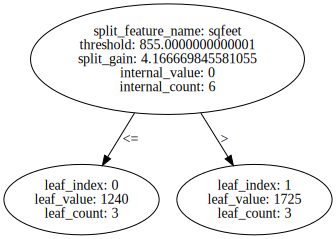

In [23]:
lightgbm.create_tree_digraph(lgbm, tree_index=0, show_info=["split_gain",
                                                 "internal_value", "internal_count", "leaf_count"] )

### Check with XGboost (can NOT)
XGboost need second derivative loss func, which mae can't have.

# Classification

# Draft

In [ ]:
kaggle = pd.read_csv("/Users/minhchau/Downloads/data_ori.txt", sep=",")
kaggle

In [ ]:
X = kaggle[["LikesGardening"]]
y = kaggle.Age
m = lightgbm.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=1, max_depth=1,
       min_child_samples=1, min_child_weight=0, min_split_gain=0.0,
       n_estimators=1, n_jobs=-1, num_leaves=31, objective="mae",
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
       subsample=1.0, subsample_for_bin=2000, subsample_freq=0)
m.fit(X, y)
lightgbm.create_tree_digraph(m, tree_index=0, show_info=["split_gain",
                                                 "internal_value", "internal_count", "leaf_count"] )

In [ ]:
m.predict(X)

In [ ]:
34.5*5/3

In [ ]:
kaggle["F0"] = kaggle.Age.median()
kaggle["residual"] = kaggle.Age - kaggle.F0
kaggle

In [ ]:
model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1, loss='lad', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=1.0, min_weight_fraction_leaf=0.0,
             n_estimators=1, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.000001,
             validation_fraction=0, verbose=0, warm_start=False)
model

model.fit(X, y)
model.predict(X)

In [ ]:
def find_duplicate_1(nums):
    a_dict = dict()
    for n in nums:  
        if n in a_dict:
            return n
        else:
            a_dict[n] = 1
    return -1


def find_duplicate_2(nums):
    a_dict = dict()
    for i in range(len(nums)):
        n = nums[i]
        if n in a_dict:
            return n
        else:
            a_dict[n] = 1
    return -1     

arr = [3,1,3,4,2]

print(find_duplicate_1(arr))
print(find_duplicate_2(arr))